In [11]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [12]:
import torchvision
from torchvision.datasets import CIFAR10

In [13]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available")
    device = torch.device("cpu")

print(f"Using device: {device}")

GPU is available
Using device: cuda


In [14]:
dataset_train = CIFAR10(root='./data',
                        train=True,
                        download=True,
                        transform=torchvision.transforms.ToTensor())
dataset_test = CIFAR10(root='./data',
                       train=False,
                       download=True,
                       transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


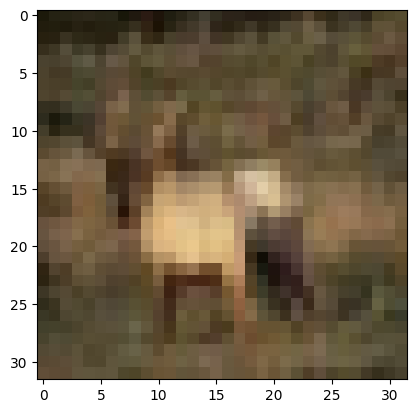

4


In [15]:
import matplotlib.pyplot as plt

index = 3

image = dataset_train[index][0]
label = dataset_train[index][1]

plt.imshow(image.permute(1, 2, 0))
plt.show()
print(label)

In [16]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
## Defining the ResNet20 Model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(256, num_classes)  # Adjusted to 256

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [20]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet20().to(device)

In [18]:
epoch_number = 100

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss_history.append(train_loss / len(train_dataloader))
    train_accuracy_history.append(100. * correct / total)
    print(f'Epoch {epoch} | Train Loss: {train_loss/len(train_dataloader):.3f} | Train Acc: {100.*correct/total:.3f}%')

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss_history.append(test_loss / len(test_dataloader))
    val_accuracy_history.append(100. * correct / total)
    print(f'Epoch {epoch} | Test Loss: {test_loss/len(test_dataloader):.3f} | Test Acc: {100.*correct/total:.3f}%')


In [ ]:
# Initialize model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Training and testing the model
epochs = epoch_number
for epoch in range(epochs):
    train(epoch)
    test(epoch)

# Plotting the loss and accuracy history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()

Epoch 0 | Train Loss: 1.894 | Train Acc: 31.350%
Epoch 0 | Test Loss: 1.612 | Test Acc: 41.860%
Epoch 1 | Train Loss: 1.358 | Train Acc: 50.726%
Epoch 1 | Test Loss: 1.360 | Test Acc: 51.830%


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.plot(val_loss_history)

NameError: name 'train_loss_history' is not defined

In [ ]:
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)

NameError: name 'train_accuracy_history' is not defined

In [ ]:
#  57.76

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(256, num_classes)  # Adjusted to 256

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        # print(out.shape)  # Debugging shape
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])

# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet20().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

epoch_number = 100

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss_history.append(train_loss / len(trainloader))
    train_accuracy_history.append(100. * correct / total)
    print(f'Epoch {epoch} | Train Loss: {train_loss/len(trainloader):.3f} | Train Acc: {100.*correct/total:.3f}%')

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss_history.append(test_loss / len(testloader))
    val_accuracy_history.append(100. * correct / total)
    print(f'Epoch {epoch} | Test Loss: {test_loss/len(testloader):.3f} | Test Acc: {100.*correct/total:.3f}%')

# Training and testing the model
epochs = epoch_number
for epoch in range(epochs):
    train(epoch)
    test(epoch)

# Plotting the loss and accuracy history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 0 | Train Loss: 1.868 | Train Acc: 32.198%
Epoch 0 | Test Loss: 1.637 | Test Acc: 39.860%
Epoch 1 | Train Loss: 1.403 | Train Acc: 48.810%
Epoch 1 | Test Loss: 1.286 | Test Acc: 54.690%
Epoch 2 | Train Loss: 1.063 | Train Acc: 62.258%
Epoch 2 | Test Loss: 1.049 | Test Acc: 63.170%
Epoch 3 | Train Loss: 0.863 | Train Acc: 69.698%
Epoch 3 | Test Loss: 1.054 | Test Acc: 64.270%
Epoch 4 | Train Loss: 0.757 | Train Acc: 73.606%
Epoch 4 | Test Loss: 0.934 | Test Acc: 68.670%
Epoch 5 | Train Loss: 0.699 | Train Acc: 75.856%
Epoch 5 | Test Loss: 0.746 | Test Acc: 73.690%
Epoch 6 | Train Loss: 0.660 | Train Acc: 77.120%
Epoch 6 | Test Loss: 0.837 | Test Acc: 71.630%
Epoch 7 | Train Loss: 0.628 | Train Acc: 78.364%
Epoch 7 | Test Loss: 0.813 | Test Acc: 73.200%
Epoch 8 | Train Loss: 0.603 | Train Acc: 79.238%
Epoch 8 | Test Loss: 0.850 | Test Acc: 72.090%
Epoch 9 | Train Loss: 0.586 | Train Acc: 79.694%
Epoch 9 | T

KeyboardInterrupt: 